# Summa control notebook

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import solargeo

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

import summapy

# Customize
sns.set_style("whitegrid")
sns.set_context('paper')
%matplotlib inline



In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

# Project specific directories
dirProj = dir_pre + 'SnowHydrology/proj/ModTsfc/'
dirPrint = dirProj + 'Graphics'
dirData = dirProj + 'data'

# Summa specific directories/names
dirSumma = dirProj + 'summa/'
projName = 'summaTestCases'

In [3]:
# Site wide arguments
os.chdir(dirData)
dat = xr.open_dataset('SWA.ModTsfc.ModelForcing.nc')
datName = 'SWA.ModTsfc.ModelForcing'
attr = xr.open_dataset('SWA.ModTsfc.Attributes.nc')
# Some issues with dates being slightly off between methods requires
# defining the beginning and end of the time record
d1 = datetime(2006, 10, 1, 0, 0, 0)
d2 = datetime(2012, 9, 30, 23, 0, 0)
utcOffest = 6 # Number of hours from UTC

siteName = 'SWA'
myDecisions = {'astability': 'louisinv',
               'subRouting': 'qInstant',
               'alb_method': 'conDecay'}
allParams = {'albedoMinWinter': 0.6,
             'albedoMinSpring': 0.25,
             'albedoDecayRate': .5*10**6}

dirModel = '/Users/karllapo/gdrive/SnowHydrology/proj/ModTsfc/summa/ModTsfc_summa/'

# ----------
# Experiment names
experiments = ['longwaveBias', 'shortwaveBias', 'specHumidBias', 'airTempBias', 'windBias', 'precipBias']
metName = {'longwaveBias': 'LWRadAtm',
           'shortwaveBias': 'SWRadAtm',
           'specHumidBias': 'spechum',
           'airTempBias': 'airtemp',
           'windBias': 'windspd',
           'precipBias': 'pptrate'}

# Experiment IDs and values
expNames = {'longwaveBias': ['lowLW', 'highLW']}
expBias = {'longwaveBias': {'lowLW': -25, 'highLW': 25}}

expNames['shortwaveBias'] = ['lowSW', 'highSW']
expBias['shortwaveBias'] = {'lowSW': -80, 'highSW': 80}

expNames['specHumidBias'] = ['lowQS', 'highQS']
expBias['specHumidBias'] = {'lowQS': -25, 'highQS': 25}

expNames['airTempBias'] = ['lowTair', 'highTair']
expBias['airTempBias'] = {'lowTair': -3, 'highTair': 3}

expNames['windBias'] = ['lowU', 'highU']
expBias['windBias'] = {'lowU': -3, 'highU': 3}

expNames['precipBias'] = ['lowP', 'obsP', 'highP']
expBias['precipBias'] = {'lowP': -50, 'obsP': 0, 'highP': 50}


In [4]:
# Calculate elevation angle
import solargeo
t = pd.date_range(d1 - timedelta(hours=utcOffest), d2 - timedelta(hours=utcOffest), freq='H')
el, _, _ = solargeo.sunae(t, dat.latitude, -dat.longitude)
dat['elevAngle'] = (('time'), el)

# Sanity check plots
# plt.plot(dat.time, np.sin(dat.elevAngle * np.pi / 180) * 1365)
# plt.plot(dat.time, dat.SWRadAtm)
# plt.gca().set_xlim(datetime(2007, 12, 1), datetime(2007, 12, 10))

# Summa control function

In [5]:
def summaControlFunc(dirModel, siteName, expName, expID, attrFile, datFile, datFileName, allParams, allDecisions):
    summapy.summaFileManager.writeDefault(dirModel, siteName, expName);
    
    summapy.summaFileManager.localAttributesFile(attrFile, dirModel, siteName, expName);

    summapy.summaFileManager.paramTrial(list(allParams.keys()), list(allParams.values()),
                                        dirModel, siteName, expName, expID);

    summapy.summaFileManager.forcingFile(dirModel, siteName, expName, datFileName,
                                         np.array(1001), xrForce=datFile, expID=expID)   ; 
    
    summapy.summaFileManager.decision(allDecisions, dirModel, siteName, expName,
                                      pd.to_datetime(datFile.time[0].values),
                                      pd.to_datetime(datFile.time[-1].values), expID=expID);
    
    summapy.summaFileManager.fileManager(dirModel, '/ModTsfc_summa/', siteName, expName, expID=expID);

In [6]:
def summaRunCommand(expNames, exp, site, fName=None):
    if fName == None:
        fName = 'run' + site + exp + '.sh'
    with open(fName, "w+") as f:
    
        f.write('''#!/bin/bash

# Used to run the test cases for SUMMA

# There are two classes of test cases:
#  1) Test cases based on synthetic/lab data; and
#  2) Test cases based on field data.

# The commands assume that you are in the directory {localInstallation}//summaTestCases/settings/
# and that the control files are in {localInstallation}//summaTestCases/settings/

# Set the SUMMA executable (e.g. /usr/local/bin/summa.exe or wherever you have installed SUMMA)

BASEDIR=`pwd`
SUMMA_EXE="docker run -v ${BASEDIR}:/ModTsfc_summa bartnijssen/summa:docker"


# *************************************************************************************************
''')
        for expID in expNames[exp]:
            fileManagerName = 'summa_fileManager_' + expID + '.txt'
            f.write('${SUMMA_EXE} -p never -s _' + expID
                    +' -m /ModTsfc_summa/settings/'
                    + exp + '/' + site + '/' + fileManagerName)
            f.write('\n')


In [7]:
# Shortwave errors that integrate to the prescribed bias over the course of a day
def prescribeShortwaveBias(dat, bias):
    # Determine the hourly radiation index
    hri = hourlyRadiationIndex(dat);

    # Error in W/m^2
    outputSW = dat.SWRadAtm + hri * 80 * (24 * 60 * 60 / dat.data_step)
    return(outputSW)

def hourlyRadiationIndex(dat):
    timeDaily = pd.date_range(dat.time.values[0], dat.time.values[-1], freq='d')
    # Empty DataArray for the hourly radiation index
    hri = xr.DataArray(np.zeros_like(dat.airtemp.squeeze('hru').values),
                       coords=[dat.time.values], dims=['time'])
    for n, days in enumerate(timeDaily[:-2]):
        elev = dat.elevAngle.loc[dict(time = slice(timeDaily[n], timeDaily[n + 1]))] * np.pi / 180
        totExposure = np.trapz(np.sin(elev))
        hri.loc[dict(time=slice(timeDaily[n], timeDaily[n + 1]))] = np.sin(elev) / totExposure
    return(hri)

In [8]:
# Relative humidity and Speicif humidity
def calc_RH(p, q, T):
    RH = np.empty_like(T)
    if np.nanmin(T) < 200:
        T = T + 273.16
    T_0 = 273.16

    RH = .263 * p * q * (np.exp( (17.67*(T - T_0)) / (T - 29.65) ))**(-1)
    RH[RH > 100] = 100
    return(RH)


def calc_QS(p, RH, T):
    if np.nanmin(T) < 200:
        T = T + 273.16
    T_0 = 273.16

    q = RH / (.263 * p) * (np.exp( (17.67*(T - T_0)) / (T - 29.65) ))
    return(q)

# Uncertainty Experiments

In [34]:
# Set up modeling decisions. Non-specified decision will follow the default values set by summa and summapy
for expN in experiments:
    if expN == 'precipBias':
        continue

    # Experiment specific files
    for expID in expNames[expN]:
        tempDat = xr.Dataset(dat)
        print(expN + ': ' + expID)
        fieldForBias = metName[expN]
        
        if expN == 'specHumidBias':
            RH = calc_RH(tempDat.airpres.values, tempDat.spechum.values, tempDat.airtemp.values)
            RH = RH + expBias[expN][expID]
            RH[RH > 100] = 100
            RH[RH < 0] = 0
            spechum = calc_QS(tempDat.airpres.values, RH, tempDat.airtemp.values)
            tempDat[fieldForBias] = (('time', 'hru'), spechum)
        
        if expN == 'shortwaveBias':
            SWRadAtm = prescribeShortwaveBias(tempDat, expBias[expN][expID])
            tempDat[fieldForBias] = SWRadAtm
        else:            
            tempDat[fieldForBias] = tempDat[fieldForBias] + expBias[expN][expID]

        tempDatName = datName + '.' + expID + '.nc'
        summaControlFunc(dirModel, siteName, expN, expID, attr, tempDat, tempDatName, allParams, myDecisions)

    # Write the shell script for running this experiment
#     os.chdir(dirModel)
#     summaRunCommand(expNames, expN, siteName)

longwaveBias: lowLW
500000.0    0.6    0.25
Finished creating new summa_zParamTrial file
Finished creating new Decision file
Finished creating new file Manager
longwaveBias: obsLW
500000.0    0.6    0.25
Finished creating new summa_zParamTrial file
Finished creating new Decision file
Finished creating new file Manager
longwaveBias: highLW
500000.0    0.6    0.25
Finished creating new summa_zParamTrial file


OSError: Permission denied

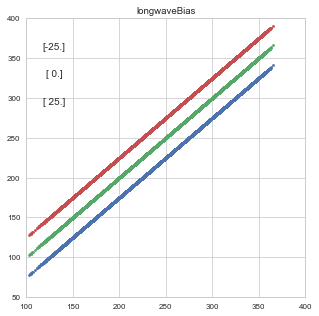

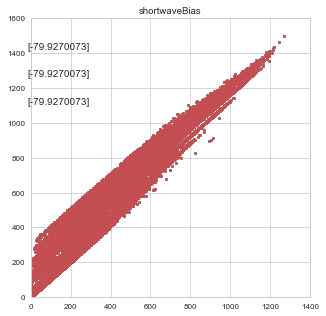

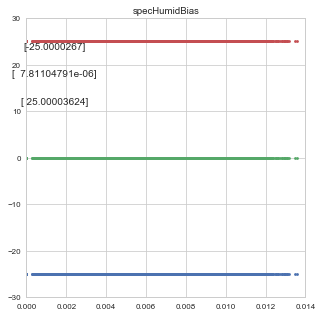

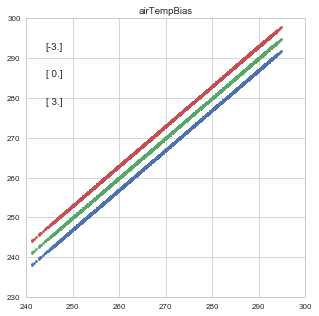

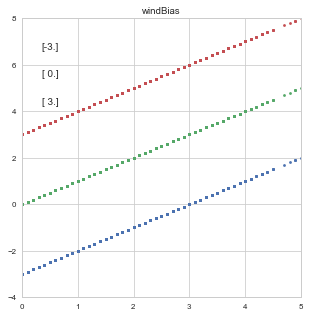

In [30]:
for expN in experiments:
    if expN == 'precipBias':
        continue

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    # Experiment specific files
    for n, expID in enumerate(expNames[expN]):
        tempDatName = datName + '.' + expID + '.nc'
        os.chdir('/Users/karllapo/gdrive/SnowHydrology/proj/ModTsfc/summa/ModTsfc_summa/input/' + expN + '/SWA/')
        fieldForBias = metName[expN]
        tempDat = xr.open_dataset(tempDatName)
        ax.plot(dat[fieldForBias], tempDat[fieldForBias], '.')
        ax.text(0.1, 0.7 + (n * 0.1), 
                str((dat[fieldForBias] - tempDat[fieldForBias]).mean(dim='time').values),
                ha='center', va='center', transform=ax.transAxes)
    ax.set_title(expN)


In [22]:
dat[fieldForBias].mean(dim='time')

<xarray.DataArray 'windspd' (hru: 1)>
array([ 1.13065], dtype=float32)
Dimensions without coordinates: hru

In [23]:
expID

'lowTair'